<a href="https://colab.research.google.com/github/fambargh/projectmastery/blob/master/seg_cup_correct_drishti_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1vfktadd
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1vfktadd
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=61973 sha256=508ff9cfff08105d1f6ac0d37f1e254fbcebb71a35b8534c439c1e2a4ed1aede
  Stored in directory: /tmp/pip-ephem-wheel-cache-8tvlrvbc/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.4
    Uninstalling albumentations-0.4.4:
      Successfully uninstalled albumentations-0.4.4


In [3]:
# Install required libs

!pip install -U --pre segmentation-models --user

In [4]:
from zipfile import ZipFile
filename = "total.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [21]:
from zipfile import ZipFile
filename = "test_folder.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x_train_dir = '/content/image_train/'
y_train_dir = '/content/annotation_cup_train/'

x_valid_dir = '/content/image_valid/'
y_valid_dir = '/content/annotation_cup_valid'

x_test_dir = '/content/test_id'
y_test_dir = '/content/test_c_d/'

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """ Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'oc','nolabeled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. oc)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

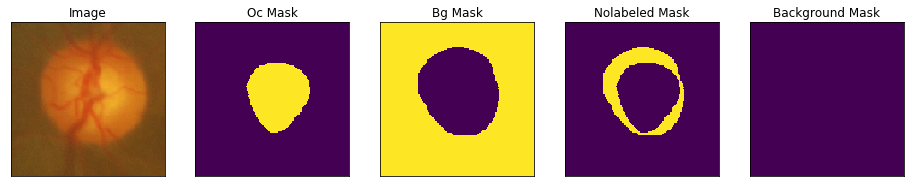

In [6]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['oc','bg','nolabeled'])

image, mask = dataset[12] # get some sample
cv2.imwrite('/content/result/0.png',image)
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    nolabeled_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

In [0]:
import albumentations as A


In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(128, 128)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


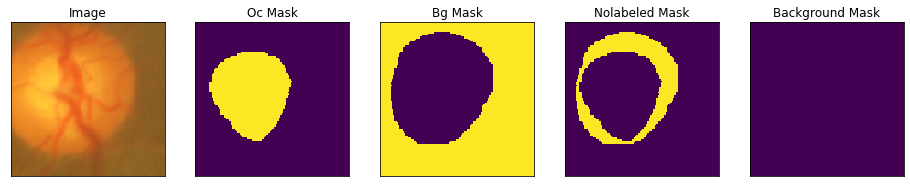

In [9]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['oc', 'bg','nolabeled'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    nolabeled_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

In [10]:
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'seresnet50'
BATCH_SIZE = 2
CLASSES = ['oc']
#LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [12]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [13]:
# define optomizer
optim = keras.optimizers.SGD(lr=0.01)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall()]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [13]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [14]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
91/91 [==============================] - 22s 240ms/step - loss: 1.1933 - iou_score: 0.2629 - f1-score: 0.3839 - precision: 0.2311 - recall: 0.5502 - val_loss: 0.8745 - val_iou_score: 0.3825 - val_f1-score: 0.4969 - val_precision: 0.2903 - val_recall: 0.6996
Epoch 2/30
91/91 [==============================] - 8s 90ms/step - loss: 0.8862 - iou_score: 0.4014 - f1-score: 0.5370 - precision: 0.3819 - recall: 0.7243 - val_loss: 0.6651 - val_iou_score: 0.4857 - val_f1-score: 0.5765 - val_precision: 0.4061 - val_recall: 0.5946
Epoch 3/30
91/91 [==============================] - 8s 91ms/step - loss: 0.7521 - iou_score: 0.4466 - f1-score: 0.5854 - precision: 0.4698 - recall: 0.7359 - val_loss: 0.6839 - val_iou_score: 0.4166 - val_f1-score: 0.5162 - val_precision: 0.4954 - val_recall: 0.4477
Epoch 4/30
91/91 [==============================] - 8s 90ms/step - loss: 0.7622 - iou_score: 0.4892 -

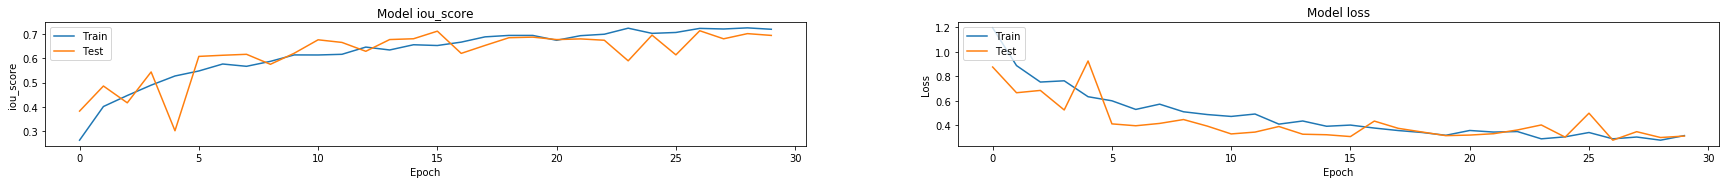

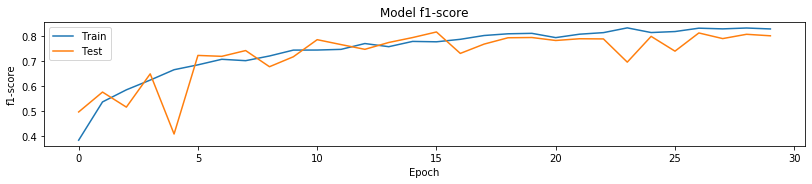

In [15]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(221)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(223)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [0]:
# load best weights
model.load_weights('best_model.h5')

In [16]:
##executing time=1.382s
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.27934
mean iou_score: 0.82287
mean f1-score: 0.8977
mean precision: 0.87181
mean recall: 0.90753


In [0]:
rm -rf /content/resault_cup_drishti

(128, 128, 3)
(128, 128)


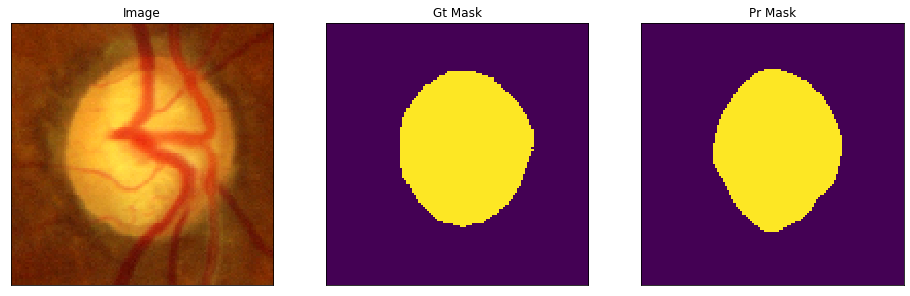

(128, 128, 3)
(128, 128)


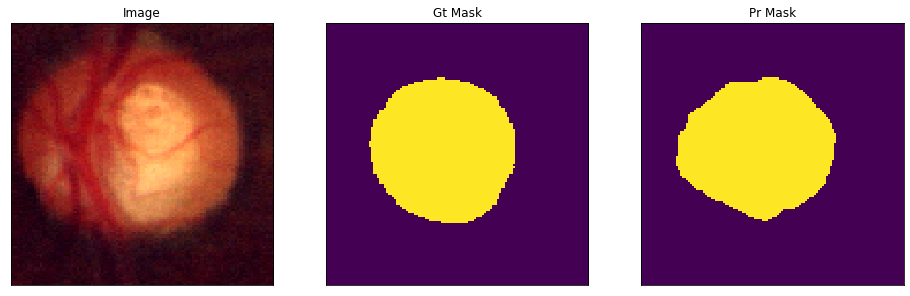

(128, 128, 3)
(128, 128)


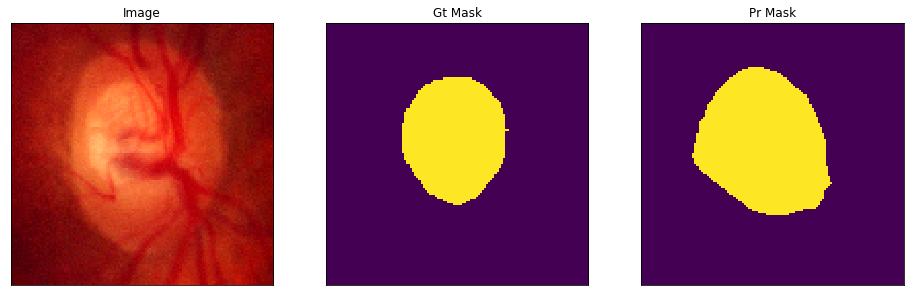

(128, 128, 3)
(128, 128)


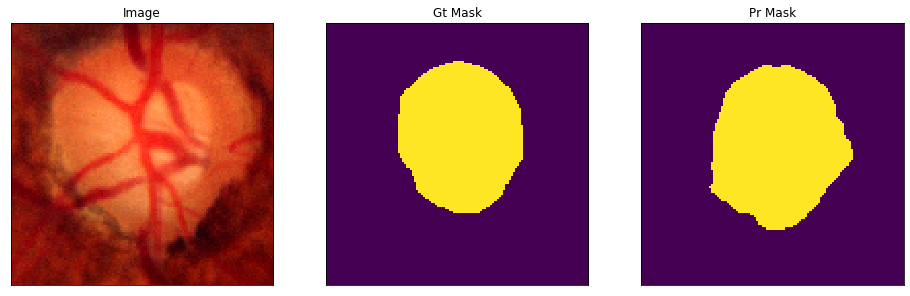

(128, 128, 3)
(128, 128)


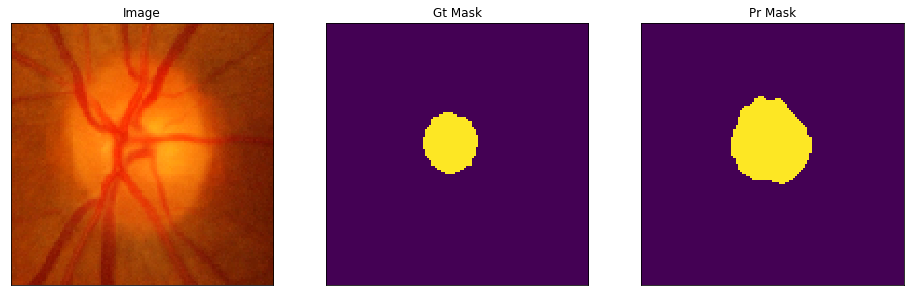

(128, 128, 3)
(128, 128)


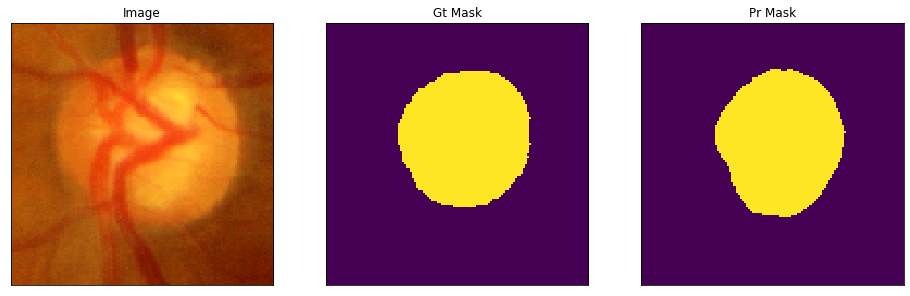

(128, 128, 3)
(128, 128)


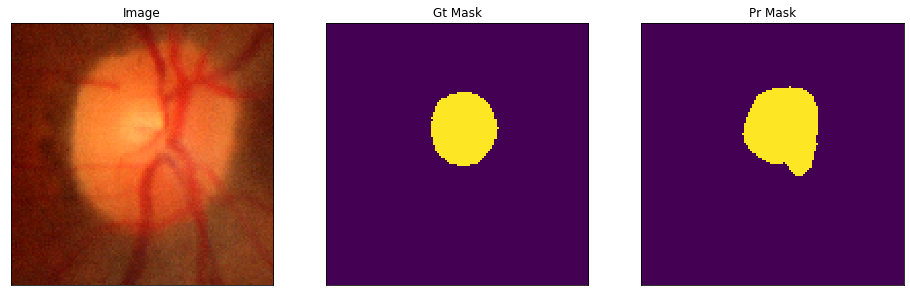

(128, 128, 3)
(128, 128)


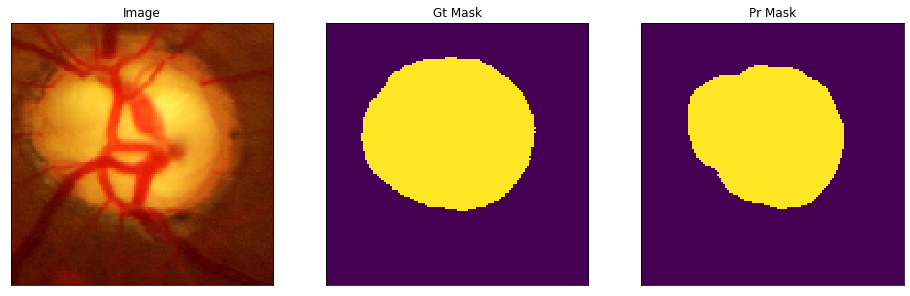

(128, 128, 3)
(128, 128)


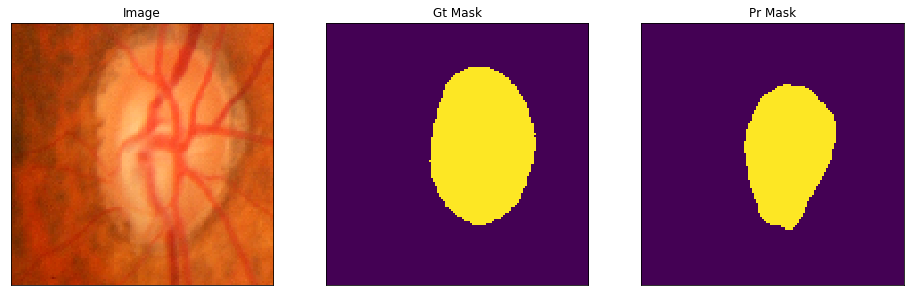

(128, 128, 3)
(128, 128)


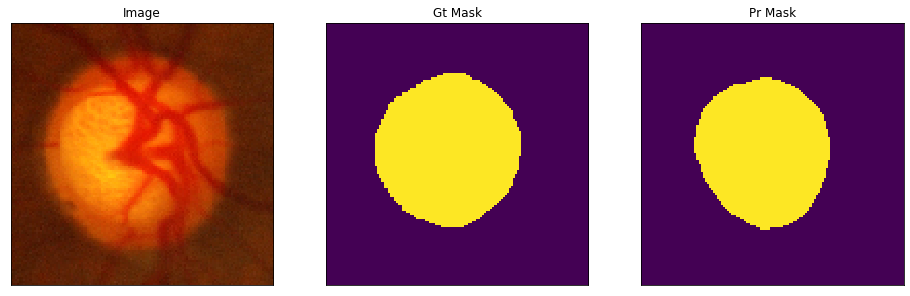

(128, 128, 3)
(128, 128)


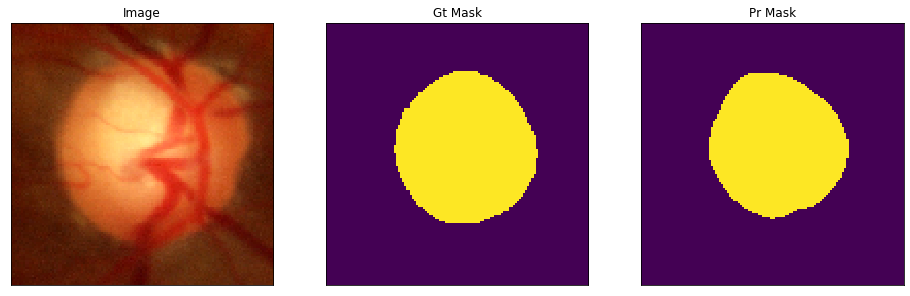

(128, 128, 3)
(128, 128)


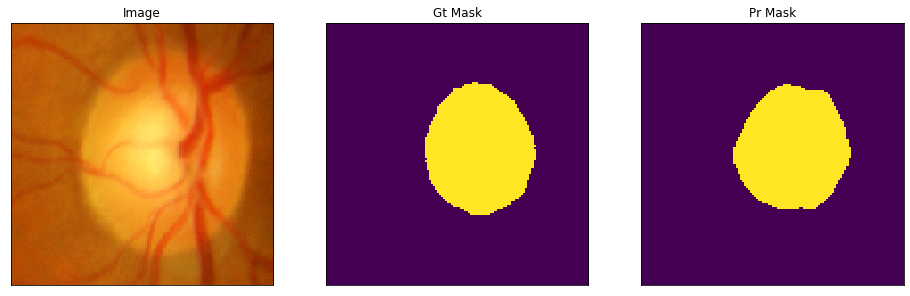

(128, 128, 3)
(128, 128)


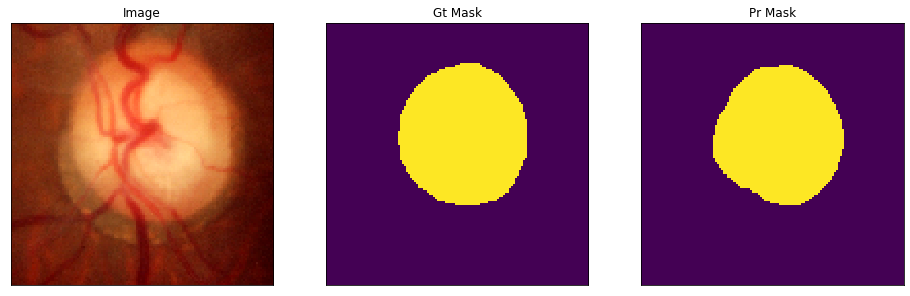

(128, 128, 3)
(128, 128)


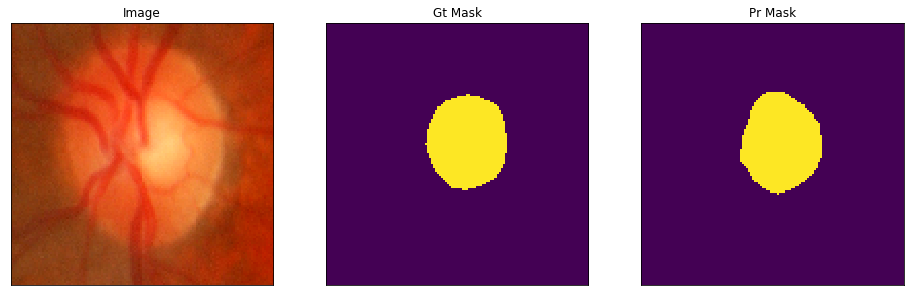

(128, 128, 3)
(128, 128)


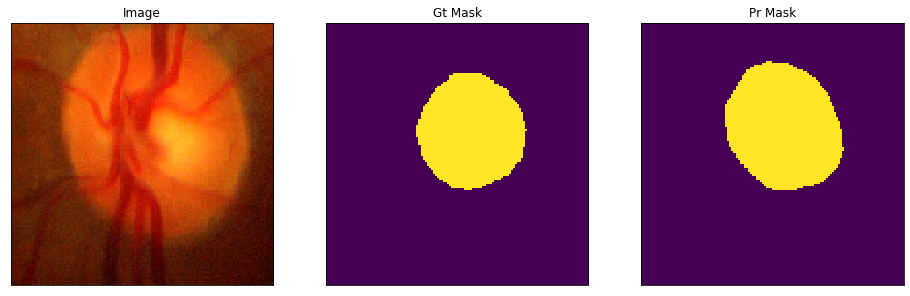

In [17]:
import numpy
for idx, img_name in enumerate(sorted(os.listdir(x_test_dir))):
  image, gt_mask = test_dataset[idx]
  print(image.shape)
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  out_arr = numpy.squeeze(pr_mask)  
  cv2.imwrite('/content/resault_cup_drishti/{}'.format(img_name),out_arr)
  print(out_arr.shape)
  visualize(
      image=denormalize(image.squeeze()),
      gt_mask=gt_mask[..., 0].squeeze(),
      pr_mask=pr_mask[..., 0].squeeze(),
      )  


In [18]:
!zip -r /content/resault_cup_drishti_sgd.zip /content/resault_cup_drishti

  adding: content/resault_cup_drishti/ (stored 0%)
  adding: content/resault_cup_drishti/drishtiGS_012.png (deflated 18%)
  adding: content/resault_cup_drishti/drishtiGS_002.png (deflated 12%)
  adding: content/resault_cup_drishti/drishtiGS_013.png (deflated 13%)
  adding: content/resault_cup_drishti/drishtiGS_003.png (deflated 13%)
  adding: content/resault_cup_drishti/drishtiGS_017.png (deflated 16%)
  adding: content/resault_cup_drishti/drishtiGS_011.png (deflated 14%)
  adding: content/resault_cup_drishti/drishtiGS_009.png (deflated 19%)
  adding: content/resault_cup_drishti/drishtiGS_010.png (deflated 15%)
  adding: content/resault_cup_drishti/drishtiGS_004.png (deflated 10%)
  adding: content/resault_cup_drishti/drishtiGS_001.png (deflated 12%)
  adding: content/resault_cup_drishti/drishtiGS_014.png (deflated 23%)
  adding: content/resault_cup_drishti/drishtiGS_007.png (deflated 27%)
  adding: content/resault_cup_drishti/drishtiGS_005.png (deflated 29%)
  adding: content/resault_

In [0]:
###when we do not use preprocessing for dataset loader
from PIL import Image
import numpy as np
for i in range(39):
  image, gt_mask = test_dataset[i]
  print(image.size)
  img = Image.fromarray(image)
  img.save('/content/resault/{}.png'.format(i))
  img.show()

  

In [0]:
for idx, img_name in enumerate(sorted(os.listdir(x_test_dir))):
  print(img_name)